### Imports

In [16]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Read in Data

In [4]:
df = pd.read_csv('Maths.csv')

### Prepare Target

<AxesSubplot:>

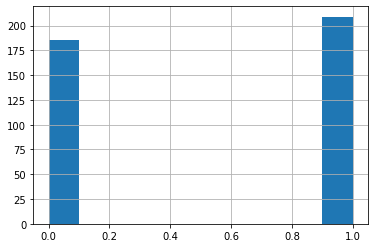

In [13]:
# Create a binary target variable. Is the total grade greater than or equal to the median or not. 
cutoff = df['G3'].median()
df['Target'] = (df['G3'] >= cutoff).astype(int)
df['Target'].hist()

### Encode Features

In [19]:
# Convert categorical variables to numerical

### Feature Selection

In [17]:
X = df.drop(columns=['Target', 'G1', 'G2', 'G3'])
y = df['Target']

In [18]:
X_new = SelectKBest(chi2, k=10).fit_transform(X, y)

ValueError: could not convert string to float: 'GP'

In [ ]:
# Compare different binary classifier models:
# - tree based
# - logistic regression
# - knn 
# - naive bayes

In [ ]:
# Show feature importance